### Imports

In [1]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingClassifier
import random
from sklearn.utils import resample


random.seed(69)

In [2]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

## Leitura do ficheiro

In [3]:
file = data_folder / "QuebrasJuntoInc.xlsx"
QuebrasFinal = pd.read_excel(file)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828,"0,0029345","0,0000443","0,0024563",...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549,"0,0029335","0,0001770","0,0165009",...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459,"0,0192281","0,0002655","0,0359047",...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102,"0,0000000","0,0000000","0,0000000",...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731,"0,0044221","0,0001549","0,0100377",...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7724,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7725,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7726,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [4]:
# Remover colunas desnecessárias
columnsRemove = ['Qualidade de Energia Elétrica', 'Qualidade de Serviço Comercial', 'Fundamentação']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

# Substituir as vírgulas por pontos nas colunas supostamente numéricas
colunas_string = QuebrasFinal.iloc[:, 5:33].select_dtypes(include=['object']).columns
QuebrasFinal[colunas_string] = QuebrasFinal[colunas_string].replace(',', '.', regex=True)

QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828,0.0029345,0.0000443,0.0024563,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549,0.0029335,0.0001770,0.0165009,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459,0.0192281,0.0002655,0.0359047,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102,0.0000000,0.0000000,0.0000000,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731,0.0044221,0.0001549,0.0100377,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7724,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7725,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7726,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [5]:
QuebrasFinal.dtypes

Código do Relatório                                  object
Concelho                                             object
Data do incidente                                    object
Nível de Tensão                                      object
Causa do incidente                                   object
Duração incidente (min)                              object
N.º clientes afetados                                object
TIEPI MT (min)                                       object
SAIFI MT (#)                                         object
SAIDI MT (min)                                       object
END (MWh)                                            object
SAIFI BT (#)                                         object
SAIDI BT (min)                                       object
Decisão                                              object
Dia                                                   int64
Mês                                                   int64
Ano                                     

In [6]:
# Lista das colunas a serem convertidas
colunas_para_converter = ['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)', 
                          'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']

# Converter as colunas para o tipo float
QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')


## Estandardizar/Normalizar os dados

In [7]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas

Index(['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)',
       'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)', 'Dia',
       'Mês', 'Ano', 'Bibliotecas e Arquivos', 'Desporto e Lazer',
       'Edifícios degradados ou devolutos', 'Espectáculos e Reuniões Públicas',
       'Estacionamento de superfície',
       'Estacionamento em profundidade ou silo', 'Habitacional',
       'Hospitalares e Lares de Idosos', 'Hotelaria e Restauração',
       'Indústria, Oficina e Armazém',
       'Militar, Forças de Segurança e Forças de Socorro',
       'Museus e Galerias de Arte', 'Parque Escolar',
       'Serviços Administrativos', 'Áreas Comerciais e Gares de Transportes',
       'Ocorrências', 'MeiosTerrestres', 'Duração Minutos',
       'Densidade Populacional', 'População Residente', 'Setor Primário',
       'Setor Secundário', 'Setor Terciário', 'Indice de Envelhecimento',
       'Rural', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED',
       'FF_MAX', 'PR_QT

In [8]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,-0.171181,828,-0.025665,-0.028259,-0.027053,...,-0.480290,-1.682177,-1.006603,-0.661436,-1.759474,NaN,NaN,NaN,NaN,-0.380843
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,-0.023331,549,-0.025666,-0.021444,-0.015615,...,0.549086,0.705019,-1.024749,-1.174245,-1.044004,0.311080,0.359270,-0.149815,-0.592508,-0.380843
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,0.569438,3459,-0.008340,-0.016899,0.000188,...,-0.882784,0.227580,-0.407763,-1.031798,0.287565,-0.167309,-0.542244,0.626530,1.163766,0.137617
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,-0.002796,102,-0.028786,-0.030534,-0.029053,...,-0.495384,0.521388,-0.698109,-0.989064,-0.467653,0.669871,-0.091487,0.414800,1.024379,1.330075
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,-0.083566,1731,-0.024084,-0.022579,-0.020878,...,2.639033,0.705019,-2.059109,-2.028927,-1.838970,-0.719296,-1.163286,0.767684,1.442540,1.680035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,0.054701,2,-0.028786,-0.030534,-0.029053,...,-0.643300,0.705019,-1.079189,-1.103021,-1.024130,NaN,NaN,NaN,NaN,-0.380843
7724,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,-0.120528,1,-0.028786,-0.030534,-0.029053,...,-0.714743,-1.682177,0.027757,-0.205605,0.665174,NaN,NaN,NaN,NaN,NaN
7725,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,-0.080828,1,-0.028786,-0.030534,-0.029053,...,-0.714743,-1.682177,0.299957,0.079289,0.625426,NaN,NaN,NaN,NaN,0.669038
7726,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,-0.035652,1,-0.028786,-0.030534,-0.029053,...,-0.307218,0.705019,-0.226296,-0.177116,0.267691,-0.268506,-0.482143,-0.361545,0.215936,NaN


## Imputação dos dados

In [9]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal


C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,-0.171181,828,-0.025665,-0.028259,-0.027053,...,-0.480290,-1.682177,-1.006603,-0.661436,-1.759474,-0.177612,-0.100727,-0.259645,-0.178095,-0.380843
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,-0.023331,549,-0.025666,-0.021444,-0.015615,...,0.549086,0.705019,-1.024749,-1.174245,-1.044004,0.311080,0.359270,-0.149815,-0.592508,-0.380843
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,0.569438,3459,-0.008340,-0.016899,0.000188,...,-0.882784,0.227580,-0.407763,-1.031798,0.287565,-0.167309,-0.542244,0.626530,1.163766,0.137617
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,-0.002796,102,-0.028786,-0.030534,-0.029053,...,-0.495384,0.521388,-0.698109,-0.989064,-0.467653,0.669871,-0.091487,0.414800,1.024379,1.330075
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,-0.083566,1731,-0.024084,-0.022579,-0.020878,...,2.639033,0.705019,-2.059109,-2.028927,-1.838970,-0.719296,-1.163286,0.767684,1.442540,1.680035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,0.054701,2,-0.028786,-0.030534,-0.029053,...,-0.643300,0.705019,-1.079189,-1.103021,-1.024130,-0.287620,-0.283327,-0.376946,-0.438405,-0.380843
7724,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,-0.120528,1,-0.028786,-0.030534,-0.029053,...,-0.714743,-1.682177,0.027757,-0.205605,0.665174,-0.143067,-0.168877,-0.113147,-0.017567,0.756621
7725,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,-0.080828,1,-0.028786,-0.030534,-0.029053,...,-0.714743,-1.682177,0.299957,0.079289,0.625426,-0.104862,-0.133351,-0.166484,-0.012696,0.669038
7726,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,-0.035652,1,-0.028786,-0.030534,-0.029053,...,-0.307218,0.705019,-0.226296,-0.177116,0.267691,-0.268506,-0.482143,-0.361545,0.215936,0.606975


In [10]:
QuebrasFinal[QuebrasFinal.isna().any(axis=1)]

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD


In [11]:
QuebrasFinal["Data do incidente"] = pd.to_datetime(QuebrasFinal["Data do incidente"])
BT = QuebrasFinal[(QuebrasFinal["Distrito"] == "Lisboa")]
BT.drop(["Nível de Tensão", "TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)"], axis = 1, inplace=True)
BT

C:\Users\diogo\AppData\Local\Temp\ipykernel_22516\3341529584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BT.drop(["Nível de Tensão", "TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)"], axis = 1, inplace=True)


,Código do Relatório,Concelho,Data do incidente,Causa do incidente,Duração incidente (min),N.º clientes afetados,END (MWh),SAIFI BT (#),SAIDI BT (min),Decisão,...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,Veículos,-0.002796,102,-0.044652,-0.039558,-0.025855,Não Aprovado,...,-0.495384,0.521388,-0.698109,-0.989064,-0.467653,0.669871,-0.091487,0.414800,1.024379,1.330075
44,EDPD_2018_FEV_T_17,Amadora,2018-02-16,Escavações,-0.193085,2451,-0.037809,-0.041554,-0.028001,Não Aprovado,...,-0.636257,-1.682177,-0.915869,-0.590212,-0.924759,1.240258,0.699842,-0.926160,-0.564631,-0.380843
45,EDPD_2018_FEV_T_18,Lisboa,2018-02-15,Escavações,-0.099994,727,0.005856,-0.028971,-0.020875,Não Aprovado,...,-0.392748,-1.682177,-0.516643,-0.789638,-0.090044,0.090285,-0.542244,-0.220392,-0.954914,-0.380843
51,EDPD_2018_FEV_T_24,Cadaval,2018-02-14,Escavações,-0.091780,1921,-0.012305,-0.008558,-0.021926,Não Aprovado,...,0.298534,0.705019,-0.625523,-0.846617,-0.328534,0.108685,-0.091487,0.767684,0.215936,-0.380843
79,EDPD_2018_MAR_T_12,Mafra,2018-03-05,Descarga Atmosférica Directa,0.455813,522,0.091615,-0.030329,-0.001679,Não Aprovado,...,-1.113211,0.705019,-0.770696,-1.103021,-0.467653,0.412278,0.699842,2.602681,2.724899,1.330075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7635,EDPD_2017_OUT_T_93,Odivelas,2017-10-24,Escavações,0.025953,1,-0.044652,-0.041825,-0.028022,Não Aprovado,...,-0.845553,-1.682177,0.662891,0.649077,0.744671,-1.639274,-1.894514,-0.502699,-0.843405,-0.380843
7672,EDPD_2017_NOV_T_1,Lisboa,2017-11-06,Escavações,-0.179395,4,-0.036772,-0.041825,-0.028046,Não Aprovado,...,-0.394761,-1.682177,-0.371469,-0.447765,-0.129793,-1.768071,-1.834413,0.203069,0.243813,-0.380843
7673,EDPD_2017_NOV_T_2,Lisboa,2017-11-23,Escavações,-0.239630,61,-0.043440,-0.040468,-0.028017,Não Aprovado,...,-0.394761,-1.682177,0.263664,-0.091647,0.883790,-0.121310,-0.031386,1.544029,1.777068,2.017034
7674,EDPD_2017_NOV_T_3,Oeiras,2017-11-14,Animais Não Aves,-0.173919,2021,-0.035560,-0.021873,-0.025194,Não Aprovado,...,-0.592989,-1.682177,-0.534789,-0.575967,-0.368282,-1.538076,-1.894514,-0.008661,-0.313734,-0.380843


In [12]:
BT.columns

Index(['Código do Relatório', 'Concelho', 'Data do incidente',
       'Causa do incidente', 'Duração incidente (min)',
       'N.º clientes afetados', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)',
       'Decisão', 'Dia', 'Mês', 'Ano', 'Distrito', 'Bibliotecas e Arquivos',
       'Desporto e Lazer', 'Edifícios degradados ou devolutos',
       'Espectáculos e Reuniões Públicas', 'Estacionamento de superfície',
       'Estacionamento em profundidade ou silo', 'Habitacional',
       'Hospitalares e Lares de Idosos', 'Hotelaria e Restauração',
       'Indústria, Oficina e Armazém',
       'Militar, Forças de Segurança e Forças de Socorro',
       'Museus e Galerias de Arte', 'Parque Escolar',
       'Serviços Administrativos', 'Áreas Comerciais e Gares de Transportes',
       'Ocorrências', 'MeiosTerrestres', 'Duração Minutos',
       'Densidade Populacional', 'População Residente', 'Setor Primário',
       'Setor Secundário', 'Setor Terciário', 'Indice de Envelhecimento',
       'Rural',

In [13]:
# Selecionar apenas as colunas relevantes
features = ['T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']
target = 'SAIDI BT (min)'
X = BT[features].values
y = BT[target].values

# Preparar os dados em sequências
def create_sequences(X, y, time_steps=7):
    X_sequence, y_sequence = [], []
    for i in range(len(X) - time_steps):
        X_sequence.append(X[i:i+time_steps])
        y_sequence.append(y[i+time_steps])
    return np.array(X_sequence), np.array(y_sequence)

time_steps = 1  # Janela de tempo de x dias
X_seq, y_seq = create_sequences(X, y, time_steps)

# Dividir os dados em conjuntos de treinamento e teste
split_ratio = 0.8
split = int(split_ratio * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')


Epoch 1/50


C:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - val_loss: 7.7491e-04
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 5.9833e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5414e-04 - val_loss: 5.8039e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 6.5725e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 5.9900e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 6.0555e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 5.9084e-04
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 6.0144e-04
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 5.7248e-04
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 5.6507e-04
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 5.6176e-04
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular o Erro Percentual Absoluto Médio (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Calcular o Coeficiente de Determinação (R²)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R-squared (R²): {r2}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Mean Absolute Error (MAE): 0.00791564843443106
Root Mean Squared Error (RMSE): 0.011185210836837052
Mean Absolute Percentage Error (MAPE): 37.90777994742191
R-squared (R²): -5.159383057100842


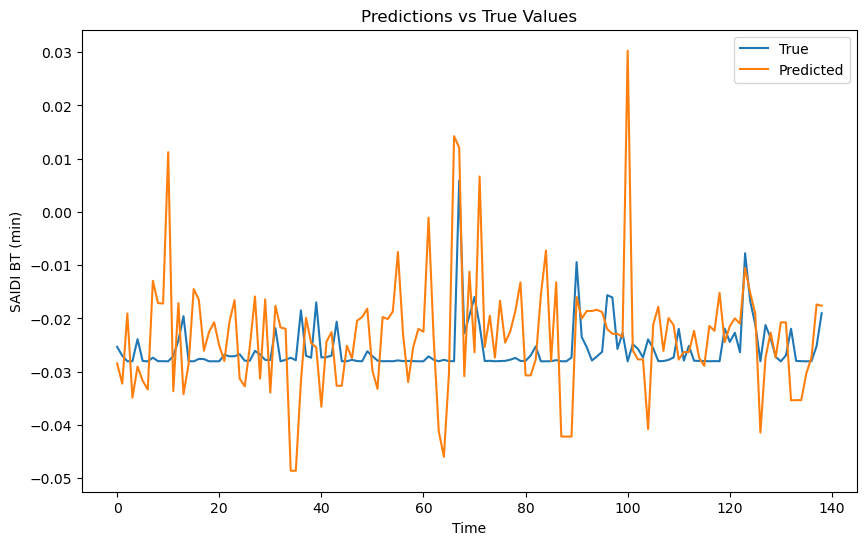

In [15]:
# Plotar as previsões vs. os valores reais
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('SAIDI BT (min)')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMindica')
plt.show()


In [16]:
BT.columns

Index(['Código do Relatório', 'Concelho', 'Data do incidente',
       'Causa do incidente', 'Duração incidente (min)',
       'N.º clientes afetados', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)',
       'Decisão', 'Dia', 'Mês', 'Ano', 'Distrito', 'Bibliotecas e Arquivos',
       'Desporto e Lazer', 'Edifícios degradados ou devolutos',
       'Espectáculos e Reuniões Públicas', 'Estacionamento de superfície',
       'Estacionamento em profundidade ou silo', 'Habitacional',
       'Hospitalares e Lares de Idosos', 'Hotelaria e Restauração',
       'Indústria, Oficina e Armazém',
       'Militar, Forças de Segurança e Forças de Socorro',
       'Museus e Galerias de Arte', 'Parque Escolar',
       'Serviços Administrativos', 'Áreas Comerciais e Gares de Transportes',
       'Ocorrências', 'MeiosTerrestres', 'Duração Minutos',
       'Densidade Populacional', 'População Residente', 'Setor Primário',
       'Setor Secundário', 'Setor Terciário', 'Indice de Envelhecimento',
       'Rural',

- - -

## Teste 2 (Nº Eventos) --

In [17]:
file = data_folder / "AllDaysEventos.parquet"
QuebrasFinal = pd.read_parquet(file)
QuebrasFinal

,Data do incidente,Concelho,Distrito,Nível de Tensão,Número de Eventos,Dia,Mês,Ano,Densidade Populacional,População Residente,...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,2014-01-01,Almada,Setúbal,Sem Eventos Excecionais,0,1,1,2014,2486.8,174592.0,...,142.4,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-01,Sertã,Castelo Branco,Sem Eventos Excecionais,0,1,1,2014,34.0,15188.0,...,219.9,1.000000,10.6,12.2,8.1,222.0,248.0,4.0,12.6,13.8
2,2014-01-01,Felgueiras,Porto,Sem Eventos Excecionais,0,1,1,2014,493.1,57074.0,...,90.1,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-01,Torres Vedras,Lisboa,Sem Eventos Excecionais,0,1,1,2014,197.2,80291.0,...,138.6,0.923077,14.4,15.2,12.0,232.0,236.0,5.4,13.4,3.8
4,2014-01-01,Nisa,Portalegre,Sem Eventos Excecionais,0,1,1,2014,12.0,6929.0,...,419.1,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008001,2023-12-31,Campo Maior,Portalegre,Sem Eventos Excecionais,0,31,12,2023,32.3,7993.0,...,163.9,1.000000,8.9,10.6,7.8,293.0,328.0,2.6,8.1,1.6
1008002,2023-12-31,Castelo De Paiva,Aveiro,Sem Eventos Excecionais,0,31,12,2023,134.1,15420.0,...,188.0,1.000000,NaN,NaN,NaN,337.0,339.0,2.6,10.1,5.8
1008003,2023-12-31,Vila Flor,Bragança,Sem Eventos Excecionais,0,31,12,2023,22.7,6042.0,...,398.0,1.000000,6.9,9.9,4.9,264.0,208.0,2.9,12.7,0.8
1008004,2023-12-31,Vimioso,Bragança,Sem Eventos Excecionais,0,31,12,2023,8.6,4143.0,...,573.7,1.000000,6.9,9.9,4.9,264.0,208.0,2.9,12.7,0.8


In [18]:
QuebrasFinal["Distrito"].unique()

array(['Setúbal', 'Castelo Branco', 'Porto', 'Lisboa', 'Portalegre',
       'Braga', 'Évora', 'Viseu', 'Aveiro', 'Faro', 'Guarda', 'Santarém',
       'Viana Do Castelo', 'Bragança', 'Vila Real', 'Leiria', 'Coimbra',
       'Beja'], dtype=object)

In [19]:
Concelho = 'Lisboa'

BT = QuebrasFinal[(QuebrasFinal["Distrito"] == Concelho) & (QuebrasFinal["Ano"] == 2018)]
BT = BT_grouped = BT.groupby(['Data do incidente', 'Dia', 'Mês', 'Ano', 
                               'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']).agg({'Número de Eventos': 'sum'}).reset_index()

# Não está a dar os 365 dias não sei porquê
BT

,Data do incidente,Dia,Mês,Ano,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Número de Eventos
0,2018-01-01,1,1,2018,12.0,16.3,8.1,277.0,270.0,1.5,7.0,0.0,0
1,2018-01-02,2,1,2018,13.0,15.9,9.1,269.0,309.0,1.8,6.9,0.0,0
2,2018-01-03,3,1,2018,14.5,17.0,12.9,284.0,309.0,2.1,6.0,0.1,0
3,2018-01-04,4,1,2018,14.3,16.3,13.3,251.0,264.0,2.8,7.9,0.8,0
4,2018-01-05,5,1,2018,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2018-12-27,27,12,2018,10.9,14.3,8.1,49.0,321.0,1.2,4.7,0.1,0
356,2018-12-28,28,12,2018,13.8,17.3,10.3,18.0,354.0,2.2,7.6,0.0,0
357,2018-12-29,29,12,2018,11.0,15.1,8.0,54.0,79.0,4.3,9.3,0.0,0
358,2018-12-30,30,12,2018,11.0,15.8,7.8,53.0,51.0,4.5,10.2,0.0,0


## Estandardizar/Normalizar os dados

In [20]:
# Selecionar as colunas numéricas
colunas_numericas = BT.select_dtypes(include=[np.number]).columns
colunas_numericas

Index(['Dia', 'Mês', 'Ano', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX',
       'FF_MED', 'FF_MAX', 'PR_QTD', 'Número de Eventos'],
      dtype='object')

## Imputação dos dados

In [21]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
BT[colunas_numericas] = imputer_mice.fit_transform(BT[colunas_numericas])

# Resultado final
BT


,Data do incidente,Dia,Mês,Ano,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Número de Eventos
0,2018-01-01,1.0,1.0,2018.0,12.0,16.3,8.1,277.0,270.0,1.5,7.0,0.0,0.0
1,2018-01-02,2.0,1.0,2018.0,13.0,15.9,9.1,269.0,309.0,1.8,6.9,0.0,0.0
2,2018-01-03,3.0,1.0,2018.0,14.5,17.0,12.9,284.0,309.0,2.1,6.0,0.1,0.0
3,2018-01-04,4.0,1.0,2018.0,14.3,16.3,13.3,251.0,264.0,2.8,7.9,0.8,0.0
4,2018-01-05,5.0,1.0,2018.0,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2018-12-27,27.0,12.0,2018.0,10.9,14.3,8.1,49.0,321.0,1.2,4.7,0.1,0.0
356,2018-12-28,28.0,12.0,2018.0,13.8,17.3,10.3,18.0,354.0,2.2,7.6,0.0,0.0
357,2018-12-29,29.0,12.0,2018.0,11.0,15.1,8.0,54.0,79.0,4.3,9.3,0.0,0.0
358,2018-12-30,30.0,12.0,2018.0,11.0,15.8,7.8,53.0,51.0,4.5,10.2,0.0,0.0


In [22]:
BT["Número de Eventos"].unique()

array([0., 1., 2.])

In [23]:
BT.columns

Index(['Data do incidente', 'Dia', 'Mês', 'Ano', 'T_MED', 'T_MAX', 'T_MIN',
       'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD', 'Número de Eventos'],
      dtype='object')

In [24]:
# Selecionar apenas as colunas relevantes
features = ['Dia', 'Mês', 'Ano', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']
target = 'Número de Eventos'
X = BT[features].values
y = BT[target].values

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calcular a proporção de classes
class_weights = len(y_train) / (5 * np.bincount(y_train.astype(int)))

# Definir a função de peso de amostra
def sample_weight_function(y):
    return class_weights[y.astype(int)]

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.001), input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=50, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(1, kernel_regularizer=L2(0.001), activation='linear')  # Ativação linear para regressão
])

# Compilar o modelo
model.compile(optimizer=Adam(), loss='mse')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1, sample_weight=sample_weight_function(y_train))

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

Epoch 1/20


C:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.7838 - val_loss: 0.2112
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7605 - val_loss: 0.1864
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2522 - val_loss: 0.1646
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9112 - val_loss: 0.1871
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7544 - val_loss: 0.2948
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4049 - val_loss: 0.2739
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5630 - val_loss: 0.2798
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4584 - val_loss: 0.2623
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5358 - val_loss: 0.2570
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4088 - val_loss: 0.2599
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3136 - val_loss: 0.2518
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3321 - val_loss: 0.2724
Epoch 13/20
8/8 ━━━━━━━

In [25]:
# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Mean Squared Error: 0.8579675820656235
R-squared: -6.173716041013212


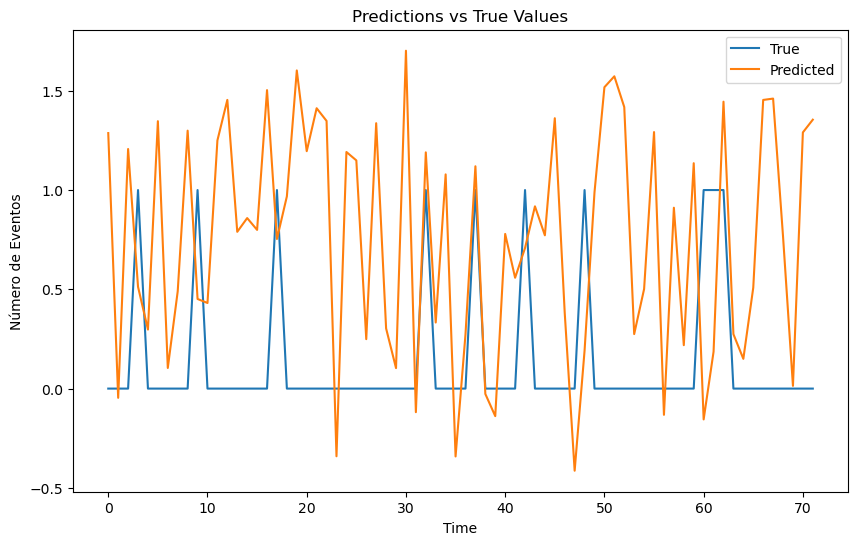

In [26]:
# Plotar as previsões vs. os valores reais
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMcount')
plt.show()


In [27]:
count_eventos = BT['Número de Eventos'].value_counts()
print(count_eventos)


Número de Eventos
0.0    323
1.0     35
2.0      2
Name: count, dtype: int64


Mean Squared Error (MSE): 0.19707628031004087
R-squared: -6.173716041013212


C:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


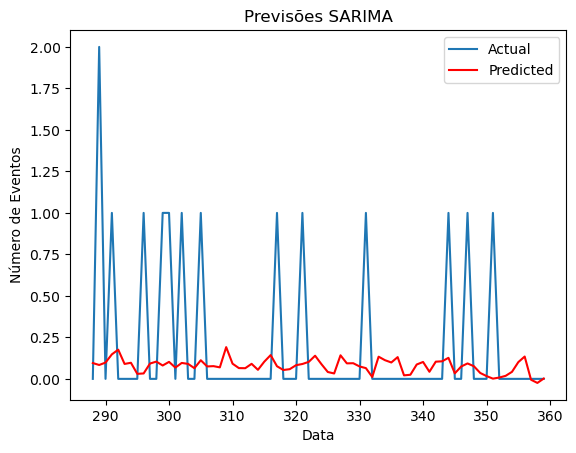

In [28]:
# Selecionar apenas as colunas relevantes
data = BT[['Número de Eventos', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']]

# Dividir os dados em conjunto de treinamento e teste
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Ajustar o modelo SARIMA
order = (1, 0, 0)  # Ordem dos termos autoregressivos (AR), diferenciação (I) e média móvel (MA)
seasonal_order = (1, 0, 0, 12)  # Ordem dos termos sazonais SAR, diferenciação (I) e média móvel (SMA), e periodicidade sazonal
model = SARIMAX(train_data['Número de Eventos'], exog=train_data.drop(columns=['Número de Eventos']), order=order, seasonal_order=seasonal_order)
sarima_result = model.fit()

# Fazer previsões
predictions = sarima_result.get_forecast(steps=len(test_data), exog=test_data.drop(columns=['Número de Eventos']))
predicted_values = predictions.predicted_mean
actual_values = test_data['Número de Eventos']

# Avaliar o modelo
mse = mean_squared_error(actual_values, predicted_values)
print(f'Mean Squared Error (MSE): {mse}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Plotar as previsões
plt.plot(actual_values.index, actual_values, label='Actual')
plt.plot(predicted_values.index, predicted_values, label='Predicted', color='red')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Número de Eventos')
plt.title('Previsões SARIMA')
plt.show()

## Teste 3 (Classificação) --

In [29]:
file = data_folder / "AllDaysEventos.parquet"
QuebrasFinal = pd.read_parquet(file)
QuebrasFinal

,Data do incidente,Concelho,Distrito,Nível de Tensão,Número de Eventos,Dia,Mês,Ano,Densidade Populacional,População Residente,...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,2014-01-01,Almada,Setúbal,Sem Eventos Excecionais,0,1,1,2014,2486.8,174592.0,...,142.4,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-01,Sertã,Castelo Branco,Sem Eventos Excecionais,0,1,1,2014,34.0,15188.0,...,219.9,1.000000,10.6,12.2,8.1,222.0,248.0,4.0,12.6,13.8
2,2014-01-01,Felgueiras,Porto,Sem Eventos Excecionais,0,1,1,2014,493.1,57074.0,...,90.1,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-01,Torres Vedras,Lisboa,Sem Eventos Excecionais,0,1,1,2014,197.2,80291.0,...,138.6,0.923077,14.4,15.2,12.0,232.0,236.0,5.4,13.4,3.8
4,2014-01-01,Nisa,Portalegre,Sem Eventos Excecionais,0,1,1,2014,12.0,6929.0,...,419.1,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008001,2023-12-31,Campo Maior,Portalegre,Sem Eventos Excecionais,0,31,12,2023,32.3,7993.0,...,163.9,1.000000,8.9,10.6,7.8,293.0,328.0,2.6,8.1,1.6
1008002,2023-12-31,Castelo De Paiva,Aveiro,Sem Eventos Excecionais,0,31,12,2023,134.1,15420.0,...,188.0,1.000000,NaN,NaN,NaN,337.0,339.0,2.6,10.1,5.8
1008003,2023-12-31,Vila Flor,Bragança,Sem Eventos Excecionais,0,31,12,2023,22.7,6042.0,...,398.0,1.000000,6.9,9.9,4.9,264.0,208.0,2.9,12.7,0.8
1008004,2023-12-31,Vimioso,Bragança,Sem Eventos Excecionais,0,31,12,2023,8.6,4143.0,...,573.7,1.000000,6.9,9.9,4.9,264.0,208.0,2.9,12.7,0.8


In [30]:
QuebrasFinal = QuebrasFinal[(QuebrasFinal["Distrito"] == "Lisboa")]

In [31]:
def existeEvento(x):
    if x > 0:
        return 1
    else:
        return 0

QuebrasFinal["HouveEventos?"] = QuebrasFinal["Número de Eventos"].apply(existeEvento)
QuebrasFinal.drop('Número de Eventos', axis = 1, inplace=True)
QuebrasFinal

C:\Users\diogo\AppData\Local\Temp\ipykernel_22516\2667743126.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QuebrasFinal["HouveEventos?"] = QuebrasFinal["Número de Eventos"].apply(existeEvento)
C:\Users\diogo\AppData\Local\Temp\ipykernel_22516\2667743126.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QuebrasFinal.drop('Número de Eventos', axis = 1, inplace=True)


,Data do incidente,Concelho,Distrito,Nível de Tensão,Dia,Mês,Ano,Densidade Populacional,População Residente,Setor Primário,...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,HouveEventos?
3,2014-01-01,Torres Vedras,Lisboa,Sem Eventos Excecionais,1,1,2014,197.2,80291.0,2152.0,...,0.923077,14.4,15.2,12.0,232.0,236.0,5.4,13.4,3.8,0
36,2014-01-01,Amadora,Lisboa,BT,1,1,2014,7227.9,171913.0,103.0,...,0.000000,14.4,15.2,12.0,232.0,236.0,5.4,13.4,3.8,1
37,2014-01-01,Lisboa,Lisboa,Sem Eventos Excecionais,1,1,2014,5425.7,542865.0,690.0,...,0.000000,14.4,15.2,12.0,232.0,236.0,5.4,13.4,3.8,0
42,2014-01-01,Cadaval,Lisboa,Sem Eventos Excecionais,1,1,2014,79.2,13847.0,524.0,...,1.000000,14.4,15.2,12.0,232.0,236.0,5.4,13.4,3.8,0
62,2014-01-01,Mafra,Lisboa,Sem Eventos Excecionais,1,1,2014,271.3,79112.0,940.0,...,1.000000,14.4,15.2,12.0,232.0,236.0,5.4,13.4,3.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007908,2023-12-31,Cascais,Lisboa,Sem Eventos Excecionais,31,12,2023,2196.1,213902.0,438.0,...,0.000000,11.9,14.3,8.9,298.0,304.0,1.7,6.8,1.1,0
1007911,2023-12-31,Vila Franca De Xira,Lisboa,Sem Eventos Excecionais,31,12,2023,433.2,137838.0,368.0,...,0.000000,11.9,14.3,8.9,298.0,304.0,1.7,6.8,1.1,0
1007920,2023-12-31,Odivelas,Lisboa,Sem Eventos Excecionais,31,12,2023,5642.2,149744.0,164.0,...,0.000000,11.9,14.3,8.9,298.0,304.0,1.7,6.8,1.1,0
1007964,2023-12-31,Lourinhã,Lisboa,Sem Eventos Excecionais,31,12,2023,184.8,27204.0,1121.0,...,1.000000,11.9,14.3,8.9,298.0,304.0,1.7,6.8,1.1,0


## Estandardizar/Normalizar os dados

In [32]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas = colunas_numericas.drop("HouveEventos?")
colunas_numericas

Index(['Dia', 'Mês', 'Ano', 'Densidade Populacional', 'População Residente',
       'Setor Primário', 'Setor Secundário', 'Setor Terciário',
       'Indice de Envelhecimento', 'Rural', 'T_MED', 'T_MAX', 'T_MIN',
       'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

In [33]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

C:\Users\diogo\AppData\Local\Temp\ipykernel_22516\3607669919.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])


,Data do incidente,Concelho,Distrito,Nível de Tensão,Dia,Mês,Ano,Densidade Populacional,População Residente,Setor Primário,...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,HouveEventos?
3,2014-01-01,Torres Vedras,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.683575,-0.430171,2.562112,...,0.863564,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
36,2014-01-01,Amadora,Lisboa,BT,-1.673749,-1.601728,-1.566743,2.356511,0.208608,-0.910669,...,-0.999289,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,1
37,2014-01-01,Lisboa,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,1.577237,2.794846,0.084217,...,-0.999289,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
42,2014-01-01,Cadaval,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.734598,-0.893411,-0.197130,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
62,2014-01-01,Mafra,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.651534,-0.438391,0.507934,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007908,2023-12-31,Cascais,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,0.180753,0.501351,-0.342889,...,-0.999289,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0
1007911,2023-12-31,Vila Franca De Xira,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,-0.581528,-0.028959,-0.461529,...,-0.999289,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0
1007920,2023-12-31,Odivelas,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,1.670852,0.054048,-0.807282,...,-0.999289,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0
1007964,2023-12-31,Lourinhã,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,-0.688937,-0.800288,0.814705,...,1.018801,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0


## Imputação dos dados

In [34]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\diogo\AppData\Local\Temp\ipykernel_22516\490769108.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])


,Data do incidente,Concelho,Distrito,Nível de Tensão,Dia,Mês,Ano,Densidade Populacional,População Residente,Setor Primário,...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,HouveEventos?
3,2014-01-01,Torres Vedras,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.683575,-0.430171,2.562112,...,0.863564,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
36,2014-01-01,Amadora,Lisboa,BT,-1.673749,-1.601728,-1.566743,2.356511,0.208608,-0.910669,...,-0.999289,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,1
37,2014-01-01,Lisboa,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,1.577237,2.794846,0.084217,...,-0.999289,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
42,2014-01-01,Cadaval,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.734598,-0.893411,-0.197130,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
62,2014-01-01,Mafra,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.651534,-0.438391,0.507934,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007908,2023-12-31,Cascais,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,0.180753,0.501351,-0.342889,...,-0.999289,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0
1007911,2023-12-31,Vila Franca De Xira,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,-0.581528,-0.028959,-0.461529,...,-0.999289,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0
1007920,2023-12-31,Odivelas,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,1.670852,0.054048,-0.807282,...,-0.999289,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0
1007964,2023-12-31,Lourinhã,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,-0.688937,-0.800288,0.814705,...,1.018801,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0


In [35]:
QuebrasFinal["HouveEventos?"].unique()

array([0, 1], dtype=int64)

In [36]:
QuebrasFinal.columns

Index(['Data do incidente', 'Concelho', 'Distrito', 'Nível de Tensão', 'Dia',
       'Mês', 'Ano', 'Densidade Populacional', 'População Residente',
       'Setor Primário', 'Setor Secundário', 'Setor Terciário',
       'Indice de Envelhecimento', 'Rural', 'T_MED', 'T_MAX', 'T_MIN',
       'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD', 'HouveEventos?'],
      dtype='object')

In [37]:
colunas_numericas

Index(['Dia', 'Mês', 'Ano', 'Densidade Populacional', 'População Residente',
       'Setor Primário', 'Setor Secundário', 'Setor Terciário',
       'Indice de Envelhecimento', 'Rural', 'T_MED', 'T_MAX', 'T_MIN',
       'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

In [38]:
colunas_variaveis = colunas_numericas.tolist()
colunas_variaveis.append('HouveEventos?')
colunas_variaveis

['Dia',
 'Mês',
 'Ano',
 'Densidade Populacional',
 'População Residente',
 'Setor Primário',
 'Setor Secundário',
 'Setor Terciário',
 'Indice de Envelhecimento',
 'Rural',
 'T_MED',
 'T_MAX',
 'T_MIN',
 'DD_MED',
 'DD_FFX',
 'FF_MED',
 'FF_MAX',
 'PR_QTD',
 'HouveEventos?']

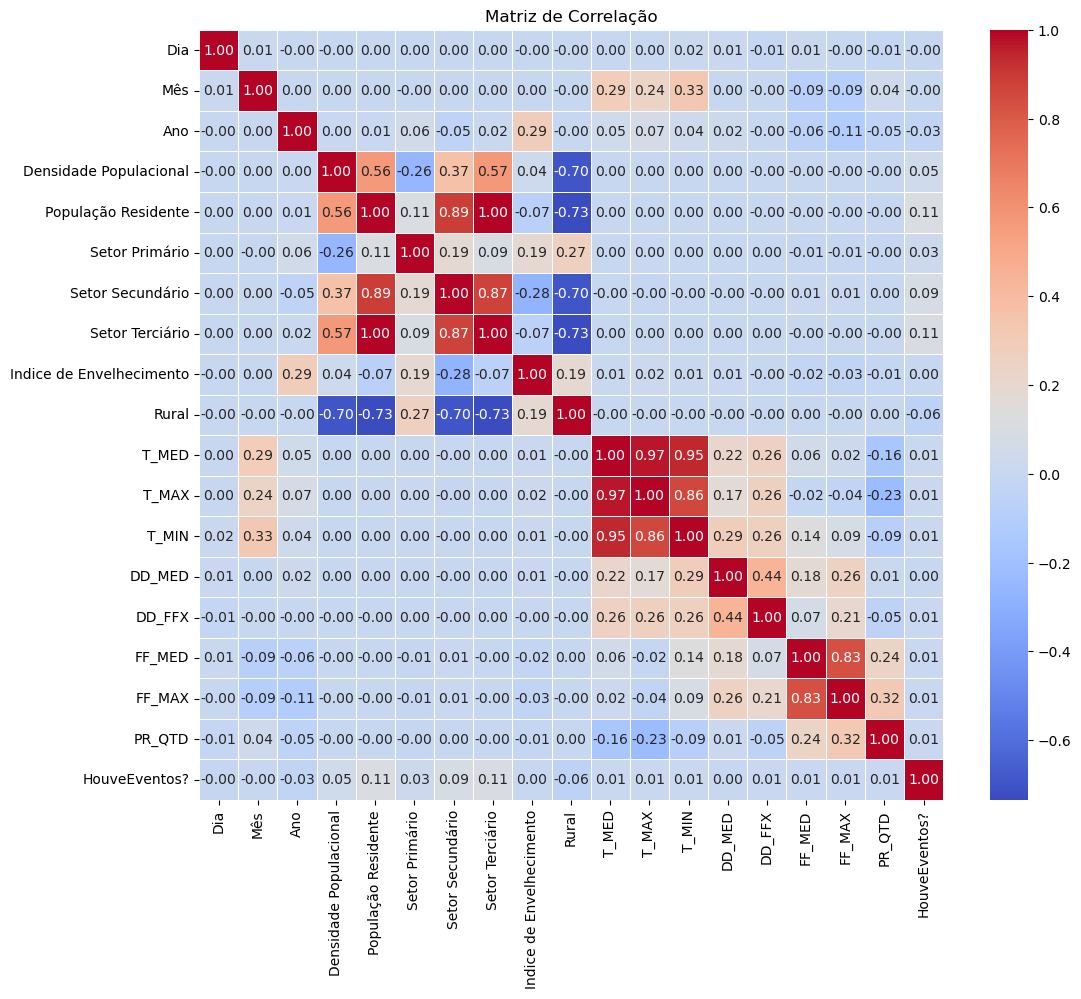

In [39]:
correlation_matrix = QuebrasFinal[colunas_variaveis].corr()
# Passo 5: Plotar um gráfico de correlações
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação")
plt.savefig("Matriz de Correlação")
plt.show()

### Original

In [40]:
# Passo 2: Dividir os dados em conjuntos de treino e teste
X = QuebrasFinal.drop(columns=['HouveEventos?', 'Data do incidente', 'Concelho', 'Distrito', 'Nível de Tensão'])
y = QuebrasFinal['HouveEventos?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 3: Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [41]:
# Passo 4: Avaliar o desempenho do modelo
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir as métricas
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.9875085557837098
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
Relatório de classificação:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     11543
           1       0.00      0.00      0.00       145

    accuracy                           0.99     11688
   macro avg       0.49      0.50      0.50     11688
weighted avg       0.98      0.99      0.98     11688



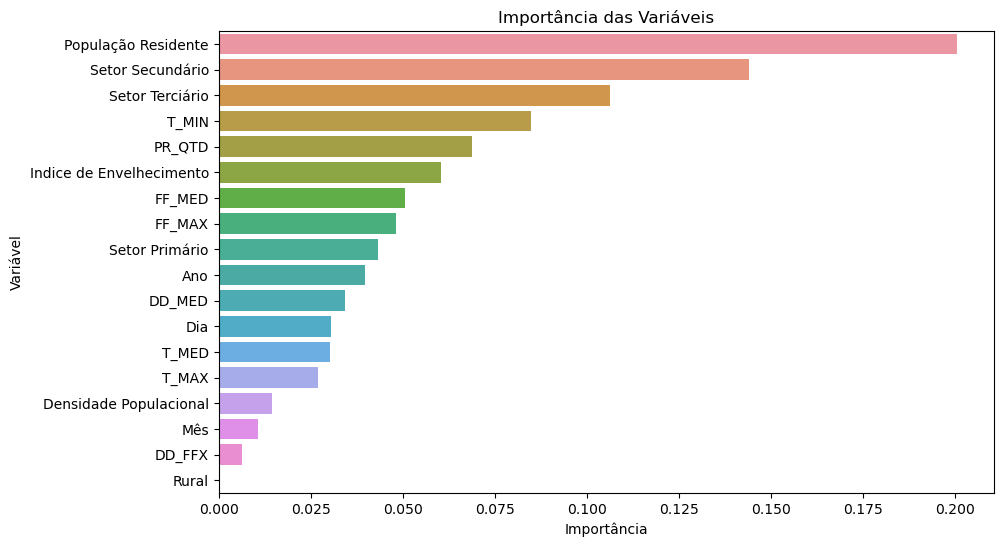

In [42]:
# Calcular a importância das variáveis
importances = gb_model.feature_importances_

# Criar um DataFrame com as importâncias das variáveis
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar as variáveis por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.savefig("OGimportanciaVariaveis")
plt.show()


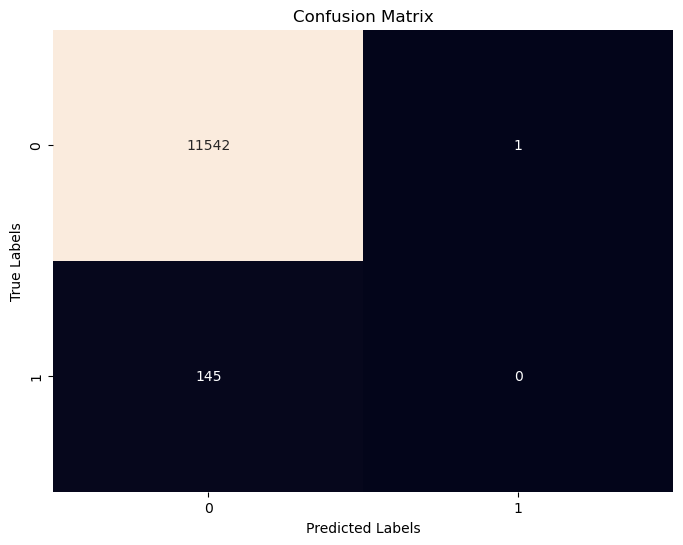

In [43]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("OGconfusionMatrix")
plt.show()


### Oversampling

In [44]:
# Separar as classes minoritárias e maioritárias
minor_class = QuebrasFinal[QuebrasFinal['HouveEventos?'] == 1]
major_class = QuebrasFinal[QuebrasFinal['HouveEventos?'] == 0]

# Fazer oversampling da classe minoritária
oversampled_minor_class = resample(minor_class, replace=True, n_samples=len(major_class), random_state=42)

# Juntar os dados da classe maioritária com a classe minoritária oversampled
oversampled_data = pd.concat([major_class, oversampled_minor_class])

# Separar as features (X) e o target (y)
X = oversampled_data.drop(columns=['HouveEventos?', 'Data do incidente', 'Concelho', 'Distrito', 'Nível de Tensão'])
y = oversampled_data['HouveEventos?']

In [45]:
oversampled_data

,Data do incidente,Concelho,Distrito,Nível de Tensão,Dia,Mês,Ano,Densidade Populacional,População Residente,Setor Primário,...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,HouveEventos?
3,2014-01-01,Torres Vedras,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.683575,-0.430171,2.562112,...,0.863564,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
37,2014-01-01,Lisboa,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,1.577237,2.794846,0.084217,...,-0.999289,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
42,2014-01-01,Cadaval,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.734598,-0.893411,-0.197130,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
62,2014-01-01,Mafra,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.651534,-0.438391,0.507934,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
98,2014-01-01,Loures,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.253206,0.400502,-0.322550,...,-0.999289,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557673,2019-07-14,Alenquer,Lisboa,MT,-0.196402,0.138165,0.174225,-0.706968,-0.686416,0.016423,...,1.018801,0.954093,0.880953,1.328957,0.655409,-0.321950,0.050867,-0.146192,-0.302700,1
659450,2020-07-17,Lisboa,Lisboa,MT,0.144524,0.138165,0.522418,1.630768,2.881040,1.002835,...,-0.999289,2.928952,2.499501,2.732046,1.100641,0.083976,-0.730893,-0.825493,-0.302700,1
330312,2017-04-11,Cascais,Lisboa,MT,-0.537329,-0.731781,-0.522162,0.168991,0.482861,-0.342889,...,-0.999289,0.678038,1.058994,0.401492,0.878025,0.489903,-0.904617,-0.578474,-0.302700,1
237707,2016-05-11,Lisboa,Lisboa,MT,-0.537329,-0.441799,-0.870356,1.600327,2.831964,0.084217,...,-0.999289,-0.765945,-0.721409,-0.502193,-0.050823,0.489903,0.224591,0.162580,3.168185,1


In [46]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [47]:
# Passo 4: Avaliar o desempenho do modelo
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir as métricas
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.758819200969571
Precisão: 0.750697350069735
Recall: 0.7605086541858
F1-score: 0.7555711528338305
Relatório de classificação:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76     11779
           1       0.75      0.76      0.76     11324

    accuracy                           0.76     23103
   macro avg       0.76      0.76      0.76     23103
weighted avg       0.76      0.76      0.76     23103



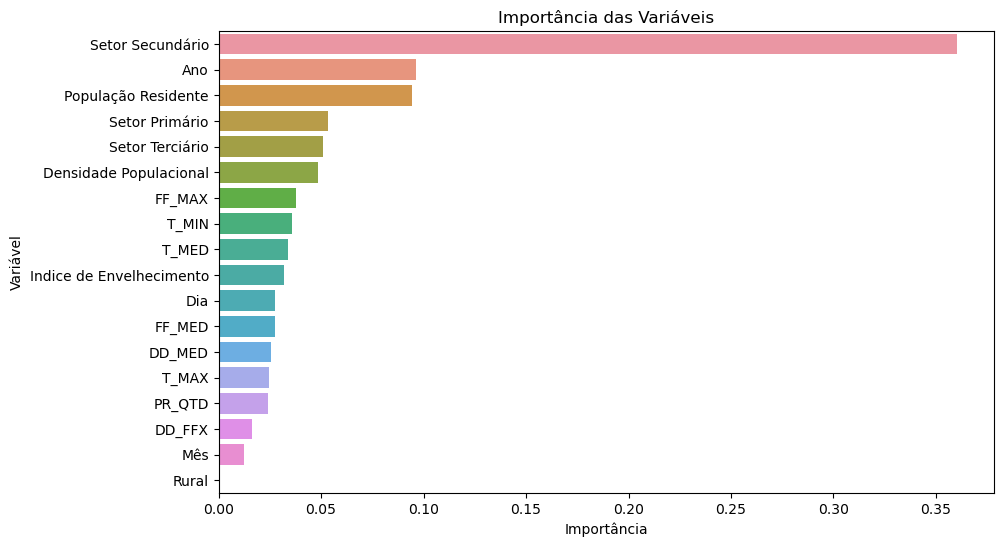

In [48]:
# Calcular a importância das variáveis
importances = gb_model.feature_importances_

# Criar um DataFrame com as importâncias das variáveis
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar as variáveis por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.savefig("OVERimportanciaVariaveis")
plt.show()


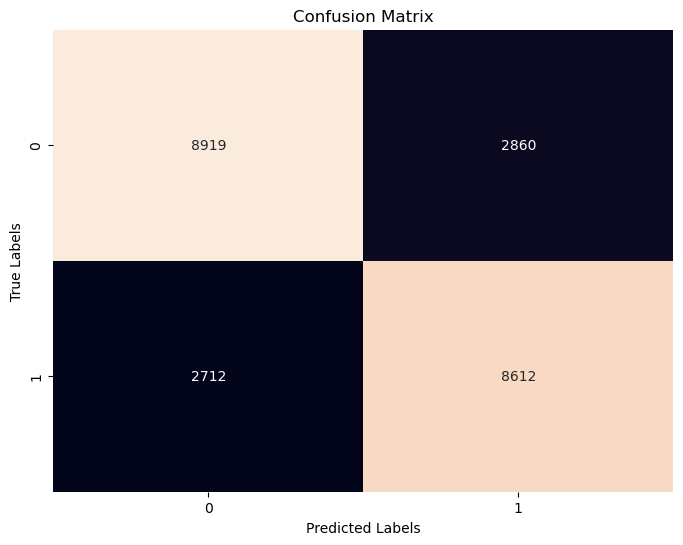

In [49]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("OVERconfusionMatrix")
plt.show()

In [50]:
conf_matrix

array([[8919, 2860],
       [2712, 8612]], dtype=int64)

### Undersampling

In [51]:
# Separar as classes minoritárias e maioritárias
minor_class = QuebrasFinal[QuebrasFinal['HouveEventos?'] == 1]
major_class = QuebrasFinal[QuebrasFinal['HouveEventos?'] == 0]

# Fazer undersampling da classe maioritária
undersampled_major_class = resample(major_class, replace=False, n_samples=len(minor_class), random_state=42)

# Juntar os dados da classe maioritária com a classe minoritária
undersampled_data = pd.concat([minor_class, undersampled_major_class])

# Separar as features (X) e o target (y)
X = undersampled_data.drop(columns=['HouveEventos?', 'Data do incidente', 'Concelho', 'Distrito', 'Nível de Tensão'])
y = undersampled_data['HouveEventos?']


In [52]:
undersampled_data

,Data do incidente,Concelho,Distrito,Nível de Tensão,Dia,Mês,Ano,Densidade Populacional,População Residente,Setor Primário,...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,HouveEventos?
36,2014-01-01,Amadora,Lisboa,BT,-1.673749,-1.601728,-1.566743,2.356511,0.208608,-0.910669,...,-0.999289,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,1
313,2014-01-02,Lisboa,Lisboa,MT,-1.560107,-1.601728,-1.566743,1.577237,2.794846,0.084217,...,-0.999289,-0.341245,-0.964191,0.377711,0.210176,-0.069374,2.656733,1.058022,0.923334,1
374,2014-01-02,Loures,Lisboa,BT,-1.560107,-1.601728,-1.566743,-0.253206,0.400502,-0.322550,...,-0.999289,-0.341245,-0.964191,0.377711,0.210176,-0.069374,2.656733,1.058022,0.923334,1
1417,2014-01-06,Lisboa,Lisboa,BT,-1.105539,-1.601728,-1.566743,1.577237,2.794846,0.084217,...,-0.999289,-0.404950,-0.883263,0.306367,-0.035470,-0.475300,2.309284,1.150654,3.289061,1
1561,2014-01-06,Vila Franca De Xira,Lisboa,MT,-1.105539,-1.601728,-1.566743,-0.583517,-0.039082,-0.454750,...,-0.999289,-0.404950,-0.883263,0.306367,-0.035470,-0.475300,2.309284,1.150654,3.289061,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265453,2016-08-19,Vila Franca De Xira,Lisboa,Sem Eventos Excecionais,0.371808,0.428148,-0.870356,-0.583344,-0.038190,-0.454750,...,-0.999289,1.123973,0.816212,1.328957,0.501880,0.489903,-0.470306,-0.671106,-0.302700,0
109425,2015-02-01,Sintra,Lisboa,Sem Eventos Excecionais,-1.673749,-1.311745,-1.218549,-0.257011,1.644511,0.279127,...,-0.999289,-1.700287,-1.449755,-1.667470,0.847319,0.940932,-0.470306,0.533108,-0.026411,0
145105,2015-06-10,Cascais,Lisboa,Sem Eventos Excecionais,-0.650971,-0.151817,-1.218549,0.159954,0.468702,-0.515765,...,-0.999289,0.571862,0.363018,0.781990,0.309969,-0.276847,0.050867,-0.146192,-0.302700,0
439303,2018-05-11,Azambuja,Lisboa,Sem Eventos Excecionais,-0.537329,-0.441799,-0.173969,-0.733906,-0.841931,-0.405599,...,1.018801,-0.383715,-0.203473,-0.454630,0.762879,0.895829,-0.035995,0.594862,-0.302700,0


In [53]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [54]:
# Passo 4: Avaliar o desempenho do modelo
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir as métricas
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.7352941176470589
Precisão: 0.75
Recall: 0.717391304347826
F1-score: 0.7333333333333333
Relatório de classificação:
               precision    recall  f1-score   support

           0       0.72      0.75      0.74       134
           1       0.75      0.72      0.73       138

    accuracy                           0.74       272
   macro avg       0.74      0.74      0.74       272
weighted avg       0.74      0.74      0.74       272



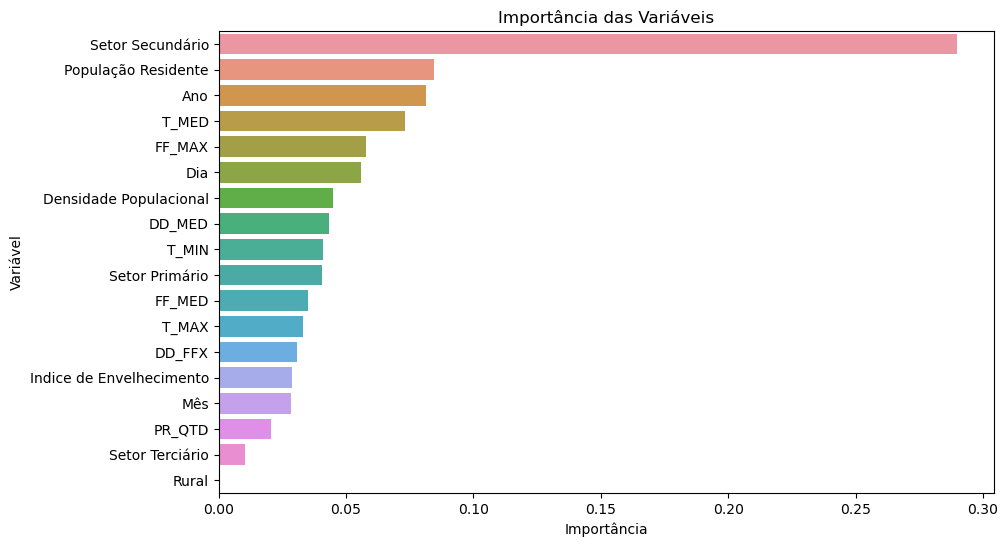

In [55]:
# Calcular a importância das variáveis
importances = gb_model.feature_importances_

# Criar um DataFrame com as importâncias das variáveis
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar as variáveis por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.show()


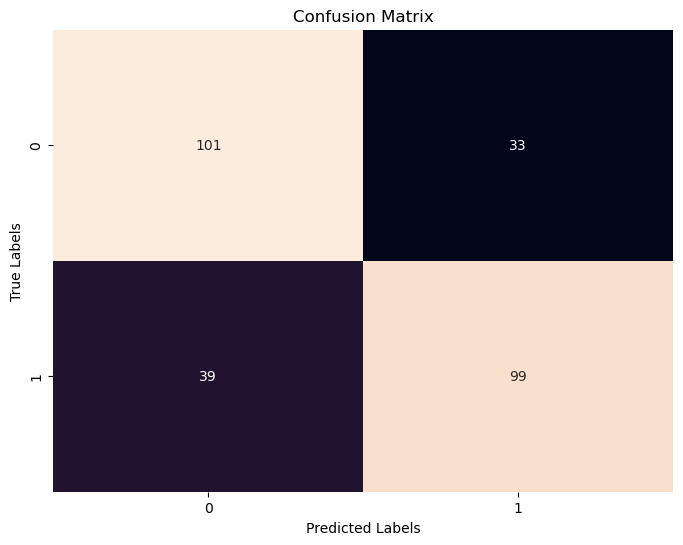

In [56]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Teste Final

In [ ]:
QuebrasFinal